In [2]:
## 加载必要的模型和参数
from saliency_maps.clip_model import load_clip_cam
from segment_anything.build_model import build_sam_predictor
from mmseg.baselines.utils import process_img_clip, get_crf_map, get_saliency_map,  get_sam_output  # 这里要加上mmseg才能正确读取成功
from baselines.sam_utils import dice_coeff
from PIL import Image
import cv2
import csv
import os
import numpy as np
import torch
from IPython.display import display
# 修改函数后，需要点击restart否则不会生效

In [1]:
!jupyter notebook list


Currently running servers:
http://localhost:51733/?token=354e92c93e9def9543525e0a12cf25d69bb650a9c20a0b0e :: /tmp/pycharm_project_659


In [7]:
# build model
clip_model, preprocess, tokenizer, cam = load_clip_cam(cache_dir='/mnt/sda/PythonProject/LocalProject_ssh/MedicalSegmentation/MedCLIPSAM_TTA/data/Pth')
sam_predictor = build_sam_predictor(model_path='/mnt/sda/Dataset/Pth/SAM')

In [20]:
# 这里看怎么设置更好的text prompt
text_prompt = [
    # positive prompt
    'An image of a fundus photographs for glaucoma assessment',
    'A detailed fundus photograph highlighting features relevant for glaucoma analysis.',
    'A high-resolution image of the optic disc from a fundus camera for glaucoma screening.',
    'A fundus photography focusing on the optic nerve head for glaucoma evaluation.',
    'An optical fundus image capturing the retinal nerve fiber layer for assessing glaucoma risk.',
    'A clinical fundus photograph used for the detection of early-stage glaucoma changes in the optic nerve head.',
    'A fundus image with clear visibility of the optic cup and rim used for diagnosing progressive glaucoma.',
    'An image showing the optic nerve head with signs of glaucoma for clinical assessment purposes.',
    # negative prompt
    'A detailed view of the retinal blood vessels in a fundus photograph for vascular study.',
    'An image showcasing the complex network of blood vessels in the fundus, without focusing on the optic disc or macular region.',
    'A fundus photograph highlighting the vascular structure, suitable for analyzing blood vessel health and abnormalities.',
    'A fundus image primarily showing the macula and fovea, without details of the optic nerve head for glaucoma.',
    'A fundus photograph focused on assessing the overall retinal health, not specifically for glaucoma detection.',
    'An image of the retina displaying general eye conditions, not related to the glaucoma or optic nerve health.',
]
tokenizer_prompts = tokenizer(text_prompt).cuda()

In [7]:
import pandas as pd
def read_csv(domain):
    result = pd.read_csv('/mnt/sda/PythonProject/LocalProject_ssh/MedicalSegmentation/MedCLIPSAM_TTA/Run/CLIPTTA/{}/result.csv'.format(domain), header=None)
    return result

In [8]:
Fundus = ['Drishti_GS', 'ORIGA', 'REFUGE', 'REFUGE_Valid', 'RIM_ONE_r3']
domain = Fundus[4]
result = read_csv(domain)
results = result[:-1].values
file_names, dice_scores, mious, clips_scores = results[:, 0], results[:, 1], results[:, 2], results[:, 3]
# 通过dice_score进行筛选
threshold = 0.7
mask_high = dice_scores > threshold
mask_low = dice_scores < 0.5  # 0.5这些是不是更高提升？

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/sda/PythonProject/LocalProject_ssh/MedicalSegmentation/MedCLIPSAM_TTA/Run/CLIPTTA/RIM_ONE_r3/result.csv'

In [130]:
# clip source能作为参考吗？这里对Fundus进行了全部的可视化，我这里保留的是An image哪个prompt是score。全部数据集证明：根据clip score是无法用来改善dice score。有时候甚至clips_scores[mask_high] < clips_scores[mask_low]
clips_scores[mask_high].mean(), clips_scores[mask_low].mean()


(34.64031513317211, 34.952300869050575)

In [5]:
from mmseg.datasets import CXR, OPTIC_dataset, OPTIC_dataset_FT
import os
def convert_labeled_list(root, csv_list):
    img_list = list()
    label_list = list()
    for csv_file in csv_list:
        data = pd.read_csv(os.path.join(root, csv_file))
        img_list += data['image'].tolist()
        label_list += data['mask'].tolist()
    return img_list, label_list

def build_dataset(root, domain, baseline='other'):
    data_csv = []

    if domain == 'cxr':
        dataset = CXR(root)

    elif domain in Fundus:
        if domain != 'REFUGE_Valid':
            data_csv.append(domain + '_train.csv')
            data_csv.append(domain + '_test.csv')
        else:
            data_csv.append(domain + '.csv')  # REFUGE_Valid没有分train and test
        ts_img_list, ts_label_list = convert_labeled_list(root, data_csv)
        if baseline == 'SAM_FT':
            dataset = OPTIC_dataset_FT(root, ts_img_list, ts_label_list)  # FT就用这个，否则改回来
        else:
            dataset = OPTIC_dataset(root, ts_img_list, ts_label_list)

    return dataset

root = '/mnt/sda/PythonProject/LocalProject_ssh/MedicalSegmentation/MedCLIPSAM_TTA/data/Segmentation/MedicalSegmentation/Fundus'
dataset = build_dataset(root, domain)
# dataset[0]

ERROR:albumentations.check_version:Error fetching version info
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/mmseg/lib/python3.9/site-packages/albumentations/check_version.py", line 32, in fetch_version_info
    data = response.read()
  File "/home/ubuntu/anaconda3/envs/mmseg/lib/python3.9/http/client.py", line 476, in read
    s = self._safe_read(self.length)
  File "/home/ubuntu/anaconda3/envs/mmseg/lib/python3.9/http/client.py", line 626, in _safe_read
    chunk = self.fp.read(min(amt, MAXAMOUNT))
  File "/home/ubuntu/anaconda3/envs/mmseg/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "/home/ubuntu/anaconda3/envs/mmseg/lib/python3.9/ssl.py", line 1241, in recv_into
    return self.read(nbytes, buffer)
  File "/home/ubuntu/anaconda3/envs/mmseg/lib/python3.9/ssl.py", line 1099, in read
    return self._sslobj.read(len, buffer)
socket.timeout: The read operation timed out


NameError: name 'domain' is not defined

In [9]:
def predict_result(file_path, gt, text_prompts, img_size=(512, 512), gt_path=None):
    cat_img, saliency_map, img_uint = get_saliency_map(file_path, text_prompts, cam, preprocess, tokenizer, img_size=img_size)
    img_np = cv2.imread(file_path)
    img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
    img_np = cv2.resize(img_np, img_size)  # 因为gt里面是1024，我都统一了
    gt = cv2.resize(gt, img_size)
    crf_img = get_crf_map(img_np, saliency_map)
    gt_np= cv2.resize(cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE), img_size, interpolation=cv2.INTER_NEAREST)
    masks = get_sam_output(sam_predictor, img_np, crf_img)
    dice_score, miou = dice_coeff(gt, masks)
    print('[dice_score: {}] and [miou: {}]'.format(dice_score, miou))
    
    crf_map = np.stack((crf_img, crf_img, crf_img), axis=-1)
    gt_np = np.stack((gt_np, gt_np, gt_np), axis=-1)
    masks = np.stack((masks, masks, masks), axis=-1)
    gt = np.stack((gt, gt, gt), axis=-1)
    img = np.hstack((img_np, saliency_map, crf_map, masks*255, gt*255, gt_np))
    return img.astype(np.uint8)

def predict_result_mat(file_path, text_prompts, img_size=(512, 512)):
    
    f = h5py.File(file, 'r')
    image = np.expand_dims(resize(f['cjdata']['image'], img_size, mode="constant", preserve_range=True), axis=-1)
    gt = resize(f['cjdata']['tumorMask'], img_size, mode="constant", preserve_range=True)
    image = np.repeat(image, 3, axis=2) / np.max(image)  * 255
    print(image.shape, gt.shape, type(image), type(gt))
    
    cat_img, saliency_map, img_uint = get_saliency_map(file_path, text_prompts, cam, preprocess, tokenizer, img_size=img_size)
    img_np = cv2.imread(file_path)
    img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
    img_np = cv2.resize(img_np, img_size)  # 因为gt里面是1024，我都统一了
    gt = cv2.resize(gt, img_size)
    crf_img = get_crf_map(img_np, saliency_map)
    masks = get_sam_output(sam_predictor, img_np, crf_img)
    dice_score, miou = dice_coeff(gt, masks)
    print('[dice_score: {}] and [miou: {}]'.format(dice_score, miou))
    
    crf_map = np.stack((crf_img, crf_img, crf_img), axis=-1)
    # gt_np = np.stack((gt_np, gt_np, gt_np), axis=-1)
    masks = np.stack((masks, masks, masks), axis=-1)
    gt = np.stack((gt, gt, gt), axis=-1)
    img = np.hstack((img_np, saliency_map, crf_map, masks*255, gt*255))
    return img.astype(np.uint8)

[dice_score: 0.428862209762935] and [miou: 0.2729628250480978]


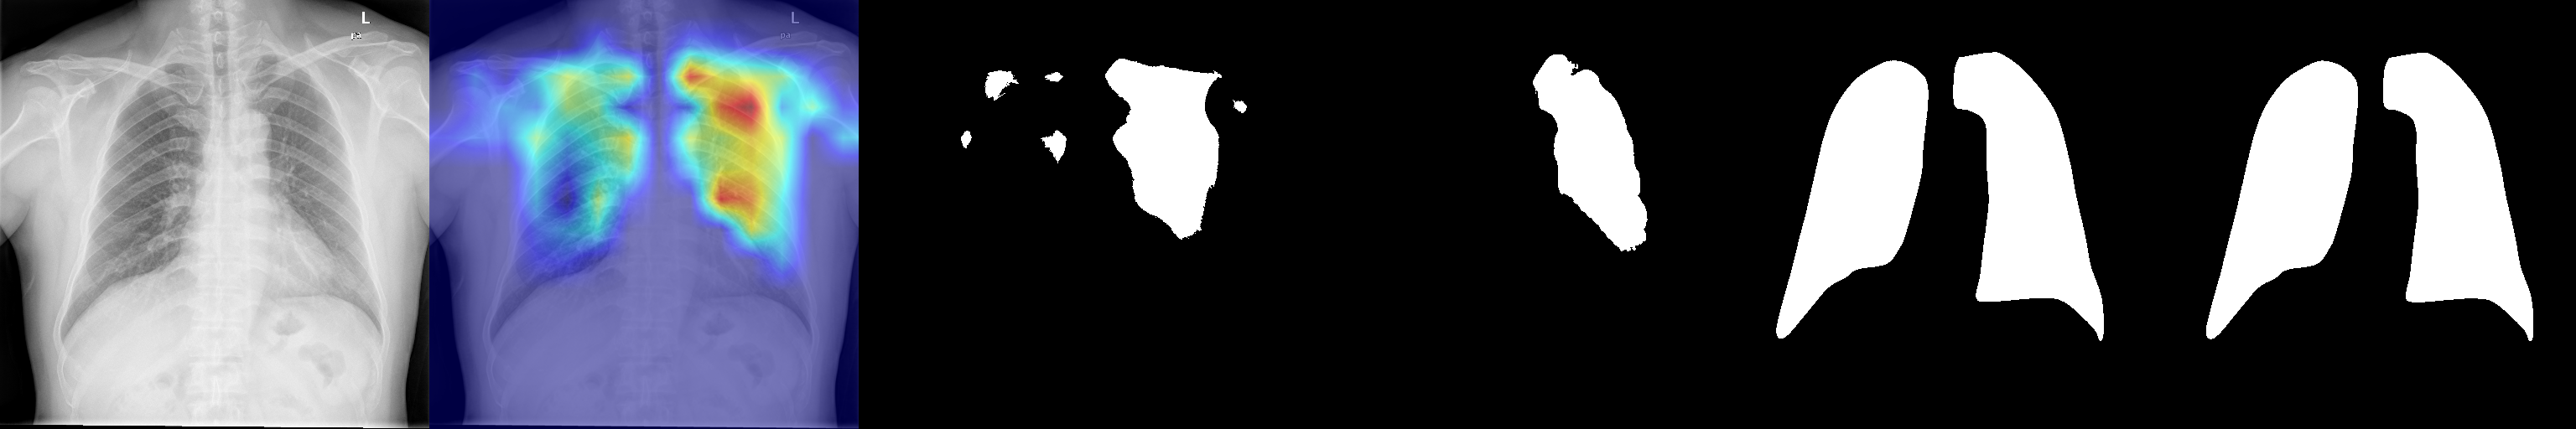

In [27]:
# BT MRI dataset
file = '/mnt/sda/Dataset/Image_DA/Segmentation/MedicalSegmentation/CXR/Lung Segmentation/CXR_png/CHNCXR_0001_0.png'
gt_path = '/mnt/sda/Dataset/Image_DA/Segmentation/MedicalSegmentation/CXR/Lung Segmentation/masks/CHNCXR_0001_0_mask.png'
text_prompt = [
        'an image of a Lung Chest X-ray',
        "The X-ray evaluates the deviation of the trachea from its normal position, indicating potential mediastinal shift or mass effect on the lungs.",
        "The X-ray detects fine linear or reticular opacities within the lung fields, indicating interstitial lung disease.",
        "The X-ray examines the appearance and distribution of bronchi and blood vessels within the lungs.",
        "The X-ray examines the borders of the lungs, assessing for normal anatomy or potential abnormalities.",
        "The X-ray assesses the structures within the mediastinum, providing insights into their impact on the adjacent lungs." 
]
gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
gt[gt==255] =1
img = predict_result(file, gt, text_prompt[0], gt_path=gt_path)
        
display(Image.fromarray(img))

[dice_score: 0.0] and [miou: 0.0]


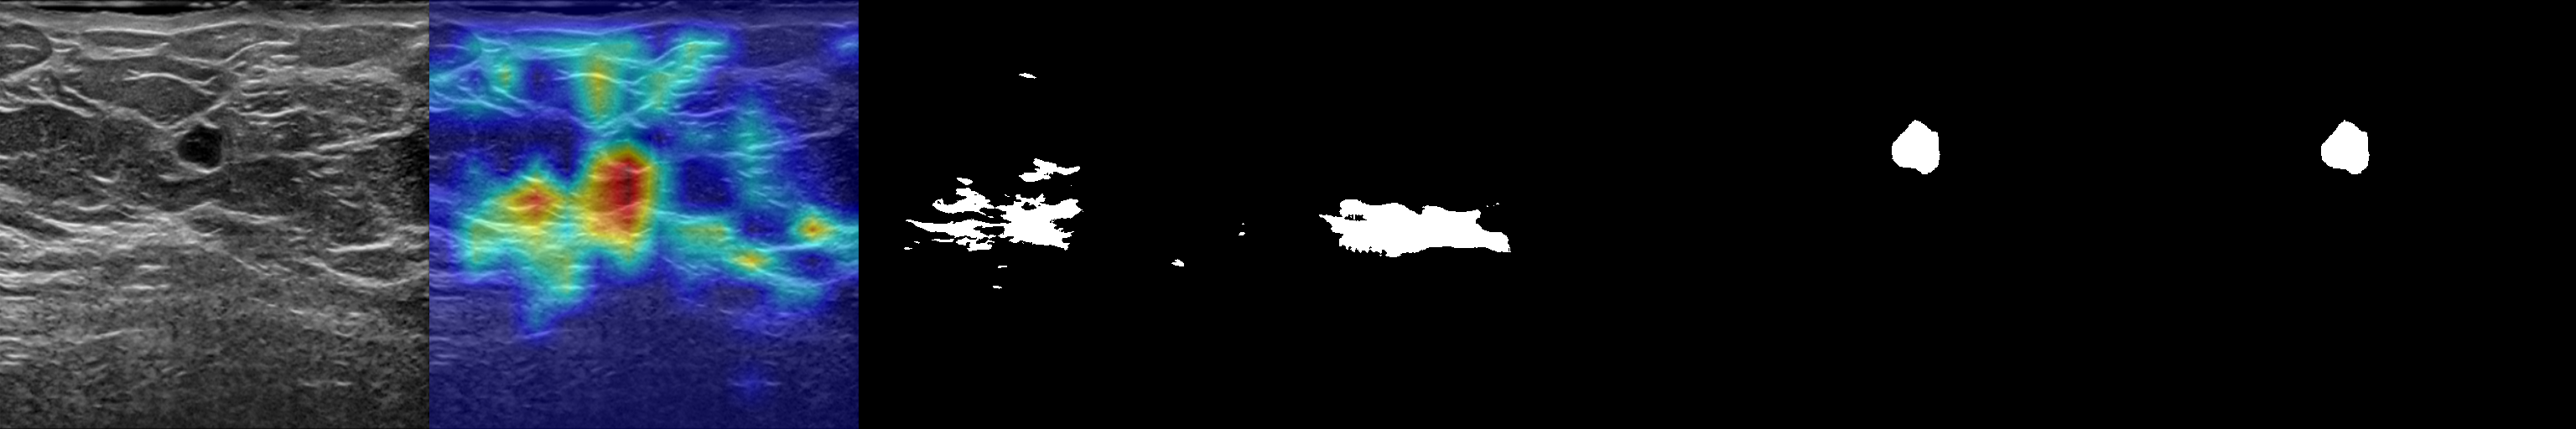

In [48]:
# 可视化---------------
# text prompt影响很大，但是自己学习一个text prompt感觉好难啊，没有checkpoint，重新训练不太work
# 这里我观察了一下，prompt-cam之间并没有强相关的关系。就算出来的score很高，但是关注区域都不一样。所以你优化一个prompt影响也不行
# 单靠clip score是真不行！！！太多情况了无法有效判断
# for data in dataset:
#     file_name = data[-1].split('/')[-1][:-4]
#     if data[-1] in mask_low_file_paths:
#         print(dice_scores[file_names == data[-1].split('/')[-1][:-4]])
#         print(analysis_clip_score(data[-1]))
#         img = predict_result(data[-1], data[1][0], text_prompt[4])
#         break

# index = 70
# data = dataset[100]
# # print(dice_scores[low_index[10]])
# # print(analysis_clip_score(data[-1]))
# img = predict_result(dataset[index]['file'], dataset[index]['gt'].numpy(), text_prompt[-1])

# 传入哪个文件和gt，gt是已经读取好的

# BUSI dataset，效果不太好
file_path = '/mnt/sda/Dataset/Image_DA/Segmentation/MedicalSegmentation/UDIAT/Benign/000035.png'
gt_path = '/mnt/sda/Dataset/Image_DA/Segmentation/MedicalSegmentation/UDIAT/Benign_mask/000035.png'
text_prompt = ['a benign and malignant tumors image',
               'An ultrasound scan image of breast cancer.',
               'The malignant tumors image shows the mass oriented in an irregular pattern, not following the typical tissue planes.',
               'The margins in the malignant tumors image are ill-defined and spiculated, suggesting invasive growth into surrounding tissues.',
               'The malignant tumors image reveals an irregular and spiculated shape, which is a common characteristic of malignancy.',
               'The malignant tumors image displays hypoechoic regions, indicating lower echogenicity compared to normal tissue.'
               ]
# print(np.unique(cv2.imread(gt_path)))
gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
gt[gt==255] = 1
img = predict_result(file_path, gt, text_prompt[0], gt_path=gt_path)
        
display(Image.fromarray(img))

In [113]:
print(img.shape)
cv2.imwrite('./c.jpg', img[:, : 1024, ::-1])

(1024, 5120, 3)


True

In [54]:
# 得重新想其他办法，比如看low freq还是看clip feature。但是感觉clip features会不太行
@torch.no_grad()
def analysis_clip_score(file_path):
    image = Image.open(file_path)
    image = preprocess(image)
    image_logits, text_logits = cam.model(image.unsqueeze(0).cuda(), tokenizer(text_prompt[:]).cuda())
    return image_logits.cpu().numpy()

In [135]:
# 看看不同image之间对prompt的敏感程度。这里基本上是某几个好一下其他都不太行
scores = []
for data in dataset:
    if data[-1].split('/')[-1][:-4] in file_names[mask_high]:
        scores.append(analysis_clip_score(data[-1]))
print(np.mean(scores, axis=0))
for data in dataset:
    if data[-1].split('/')[-1][:-4] in file_names[mask_low]:
        scores.append(analysis_clip_score(data[-1]))
print(np.mean(scores, axis=0))

[[34.74049  36.08381  38.74364  36.420204 36.199207 37.79061  37.894844
  40.206116 36.450283 32.31456  35.742725 35.97301  34.08059  34.34234 ]]
[[34.746906 36.304203 39.032764 36.363453 36.34899  37.805542 37.786205
  40.259663 36.608685 32.456253 35.87049  35.97734  34.504593 34.410137]]


In [14]:
# 看看不同text prompt造成的影响
print(len(dataset))
mask_high_file_paths, mask_low_file_paths = [], []
high_index, low_index = [], []
for i, data in enumerate(dataset):
    file_name = data[-1].split('/')[-1][:-4]
    if dice_scores[file_names == file_name] > 0.8:
        mask_high_file_paths.append(data[-1])
        high_index.append(i)
        
    elif dice_scores[file_names == file_name] < 0.5:
        mask_low_file_paths.append(data[-1])
        low_index.append(i)
print(len(mask_high_file_paths), len(mask_low_file_paths), len(high_index), len(low_index))

159


KeyError: -1

In [53]:
# 可视化---------------
# text prompt影响很大，但是自己学习一个text prompt感觉好难啊，没有checkpoint，重新训练不太work
# 这里我观察了一下，prompt-cam之间并没有强相关的关系。就算出来的score很高，但是关注区域都不一样。所以你优化一个prompt影响也不行
# 单靠clip score是真不行！！！太多情况了无法有效判断
# for data in dataset:
#     file_name = data[-1].split('/')[-1][:-4]
#     if data[-1] in mask_low_file_paths:
#         print(dice_scores[file_names == data[-1].split('/')[-1][:-4]])
#         print(analysis_clip_score(data[-1]))
#         img = predict_result(data[-1], data[1][0], text_prompt[4])
#         break


data = dataset[0]
# print(dice_scores[low_index[10]])
# print(analysis_clip_score(data[-1]))
img = predict_result(dataset[0]['file'], dataset[0]['gt'], text_prompt[:])
        
display(Image.fromarray(img))

(512, 512, 3)


ValueError: could not broadcast input array from shape (262144,) into shape (640000,)

In [202]:
data = dataset[high_index[10]]
print(dice_scores[high_index[10]])
print(analysis_clip_score(data[-1]))
img = predict_result(data[-1], data[1][0], text_prompt[:])

0.878523052446664
[[34.83127  36.05983  39.03164  35.943268 35.7069   37.685547 37.88285
  39.297436 37.047546 33.106388 36.303654 37.08416  35.211266 34.214104]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]
[dice_score: 0.3893400332002333] and [miou: 0.24172701949860725]


In [204]:
result

,0,1,2,3
0,G-1-L,0.820224,0.695237,37.910221
1,G-10-L,0.579814,0.408266,37.543465
2,G-11-R,0.949546,0.903938,35.260792
3,G-12-L,0.596960,0.425477,36.424438
4,G-13-R,0.588664,0.417097,36.165657
...,...,...,...,...
155,S-6-R,0.000000,0.000000,32.451118
156,S-7-L,0.377732,0.232842,33.824249
157,S-8-R,0.461331,0.299825,33.213699
158,S-9-L,0.000000,0.000000,33.621780


In [238]:
!jupyter notebook list

Currently running servers:
http://localhost:45369/?token=8dc70be32d1c43d9d3a3d7c35780c148c015692e1f61432d :: /mnt/sda/PythonProject/LocalProject_ssh/MedicalSegmentation/MedCLIPSAM_TTA
http://localhost:37745/?token=eab25aa1a895c0b7fc98b987073e993ca6cdd1b519be9509 :: /mnt/sda/PythonProject/LocalProject_ssh/MedicalSegmentation/MedCLIPSAM_TTA


In [239]:
!jupyter notebook stop 37745

^C
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/mmseg/bin/jupyter-notebook", line 8, in <module>
    sys.exit(main())
  File "/home/ubuntu/anaconda3/envs/mmseg/lib/python3.9/site-packages/jupyter_server/extension/application.py", line 623, in launch_instance
    serverapp.start()
  File "/home/ubuntu/anaconda3/envs/mmseg/lib/python3.9/site-packages/jupyter_server/serverapp.py", line 3120, in start
    self.start_app()
  File "/home/ubuntu/anaconda3/envs/mmseg/lib/python3.9/site-packages/jupyter_server/serverapp.py", line 2989, in start_app
    super().start()
  File "/home/ubuntu/anaconda3/envs/mmseg/lib/python3.9/site-packages/jupyter_core/application.py", line 270, in start
    self.subapp.start()
  File "/home/ubuntu/anaconda3/envs/mmseg/lib/python3.9/site-packages/jupyter_server/serverapp.py", line 732, in start
    self._shutdown_or_exit(port, server)
  File "/home/ubuntu/anaconda3/envs/mmseg/lib/python3.9/site-packages/jupyter_server/serverapp.py", line 

In [161]:
# 读取brain_tumor_mri
import scipy.io

import h5py
file = '/mnt/sda/Dataset/Image_DA/Segmentation/MedicalSegmentation/brain_tumor_mri/dataset/data/1669.mat'

# 打开HDF5文件
f = h5py.File(file, 'r')
print(f)
for name in f['cjdata']:
    print(name)
print(f['cjdata']['image'])
print(f['cjdata']['label'])
# f.close()

<HDF5 file "1669.mat" (mode r)>
PID
image
label
tumorBorder
tumorMask
<HDF5 dataset "image": shape (512, 512), type "<i2">
<HDF5 dataset "label": shape (1, 1), type "<f8">


In [236]:
image = f['cjdata']['PID'][:]
# print(np.unique(image))
f['cjdata']['PID'][:]


<HDF5 dataset "PID": shape (6, 1), type "<u2">

[   0    1    2 ... 3562 3591 3750]


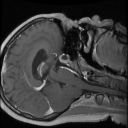

In [216]:
from skimage.transform import resize
im = np.expand_dims(resize(image, (128, 128), mode="constant", preserve_range=True), axis=-1)
im = np.repeat(im, 3, axis=2) / 3075  * 255
print(np.unique(image))
display(Image.fromarray(im.astype(np.uint8)))

Image.fromarray(im.astype(np.uint8)).save('./a.jpg')

(512, 512) [0 1] 0 1


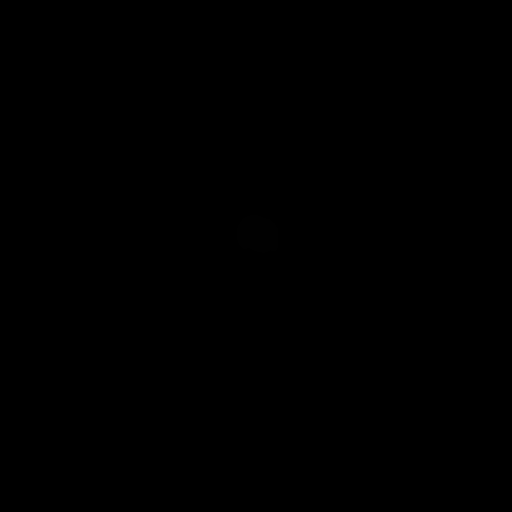

In [237]:
image = f['cjdata']['tumorMask'][:]
print(image.shape, np.unique(image), np.min(image), np.max(image))
import matplotlib.pyplot as plt
# plt.imshow(image*255)
display(Image.fromarray(image.astype(np.uint8)))
Image.fromarray(image.astype(np.uint8)).save('./b.jpg')